In [1]:
from loader.Pouring_dataset import Pouring
from models.mmp import NRMMP
from models.modules import FC_SE32vec, FC_vec2SE3

import torch

import copy

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

import matplotlib.pyplot as plt

device = f'cuda:0'
use_pretrained = True

In [2]:
ds = Pouring(graph={'bs_nn': 2, 'num_nn': 6, 'include_center': True, 'replace': False})
dl = torch.utils.data.DataLoader(ds, batch_size=10)
encoder = FC_SE32vec(
    in_chan=480*12,
    out_chan=2,
    l_hidden=[2048, 1024, 512, 256, ],
    activation=['gelu', 'gelu', 'gelu', 'gelu',],
    out_activation='linear'
)
decoder = FC_vec2SE3(
    in_chan=2,
    out_chan=480*6,
    l_hidden=[256, 512, 1024, 2048, ],
    activation=['gelu', 'gelu', 'gelu', 'gelu',],
    out_activation='linear'
)
mmp = NRMMP(encoder, decoder, approx_order=1, kernel={'type': 'binary', 'lambda':0.05})
mmp.to(device)

Pouring dataset is ready; # of trajectories: 10


NRMMP(
  (encoder): FC_SE32vec(
    (net): Sequential(
      (0): Linear(in_features=5760, out_features=2048, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=2048, out_features=1024, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): GELU(approximate='none')
      (6): Linear(in_features=512, out_features=256, bias=True)
      (7): GELU(approximate='none')
      (8): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (decoder): FC_vec2SE3(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=512, out_features=1024, bias=True)
      (5): GELU(approximate='none')
      (6): Linear(in_features=1024, out_features=2048, bias=True)
      (7): GELU(approximate='none')
      (8): Linear(i

In [3]:
if use_pretrained:
    load_dict = torch.load("results/nrmmp.pkl", map_location='cpu')
    ckpt = load_dict["model_state"]
    mmp.load_state_dict(ckpt)
    list_encoded_data = load_dict["list_encoded_data"]
    best_mmp = copy.copy(mmp)
else:
    list_encoded_data = []
    best_val_loss = torch.inf
    opt = torch.optim.Adam(mmp.parameters(), lr=0.0001)
    for epoch in range(1000):
        for x_c, x_nn, _ in dl:
            results = mmp.train_step(x_c.to(device), x_nn.to(device), optimizer=opt)
        if epoch%10 == 0:
            val_loss = mmp.validation_step(ds.traj_data_.to(device))['loss']
            print(f"[Epoch {epoch}] Train loss: {results['loss']} Val loss: {val_loss}")
            list_encoded_data.append(mmp.encode(ds.traj_data_.to(device)).detach().cpu())
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_mmp = copy.copy(mmp)
                print(f"best_val_loss is updated to {best_val_loss}")
    torch.save({
        "list_encoded_data": list_encoded_data, 
        "model_state": best_mmp.state_dict()
    }, "results/nrmmp.pkl")

[Epoch 0] Train loss: 706.2838134765625 Val loss: 16.191680908203125
best_val_loss is updated to 16.191680908203125
[Epoch 10] Train loss: 631.7606811523438 Val loss: 13.674067497253418
best_val_loss is updated to 13.674067497253418
[Epoch 20] Train loss: 255.8179931640625 Val loss: 4.202352046966553
best_val_loss is updated to 4.202352046966553
[Epoch 30] Train loss: 78.86698913574219 Val loss: 1.1962851285934448
best_val_loss is updated to 1.1962851285934448
[Epoch 40] Train loss: 57.05780792236328 Val loss: 0.8748362064361572
best_val_loss is updated to 0.8748362064361572
[Epoch 50] Train loss: 48.23323059082031 Val loss: 0.745579183101654
best_val_loss is updated to 0.745579183101654
[Epoch 60] Train loss: 47.6359748840332 Val loss: 0.6787898540496826
best_val_loss is updated to 0.6787898540496826
[Epoch 70] Train loss: 48.85026550292969 Val loss: 0.6723041534423828
best_val_loss is updated to 0.6723041534423828
[Epoch 80] Train loss: 40.262962341308594 Val loss: 0.6188675165176392

In [4]:
def update(epoch):
    plt.figure(figsize=(3,3))
    for z_data, l in zip(list_encoded_data[epoch], ds.labels_):
        if l[0] == 0:
            c = 'lightskyblue'
        else:
            c = 'darkmagenta'
        if l[1] == 0:
            s = 50
        else:
            s = 100
        if l[2] == 1:
            marker = '<'
        elif l[2] == 2:
            marker = '3'
        elif l[2] == 3:
            marker = '+'
        elif l[2] == 4:
            marker = '4'
        elif l[2] == 5:
            marker = '>'
        plt.scatter(z_data[0], z_data[1], s=s, c=c, marker=marker)

In [5]:
interactive_plot = interactive(update, epoch = widgets.IntSlider(
    value=0,
    min=0,
    max=len(list_encoded_data)-1,
    step=1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=0, description='epoch', max=99), Output(layout=Layout(height='350px'))),…

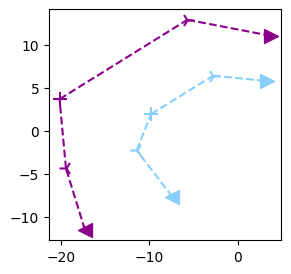

In [7]:
plt.figure(figsize=(3, 3))
encoded_data = best_mmp.encode(ds.traj_data_.to(device)).detach().cpu()
for z_data, l in zip(encoded_data, ds.labels_):
    if l[0] == 0:
        c = 'lightskyblue'
    else:
        c = 'darkmagenta'
    if l[1] == 0:
        s = 50
    else:
        s = 100
    if l[2] == 1:
        marker = '<'
    elif l[2] == 2:
        marker = '3'
    elif l[2] == 3:
        marker = '+'
    elif l[2] == 4:
        marker = '4'
    elif l[2] == 5:
        marker = '>'
    plt.scatter(z_data[0], z_data[1], s=s, c=c, marker=marker)
data1 = encoded_data[ds.labels_[:, 0]==0]
data2 = encoded_data[ds.labels_[:, 0]==1]
for x1, x2 in zip(data1[:-1], data1[1:]):
    plt.plot([x1[0], x2[0]], [x1[1], x2[1]], '--', c='lightskyblue')
for x1, x2 in zip(data2[:-1], data2[1:]):
    plt.plot([x1[0], x2[0]], [x1[1], x2[1]], '--', c='darkmagenta')
plt.show()